In [40]:
from mpl_toolkits.mplot3d import Axes3D
from utils.utils import *
from utils.visualization import *
from utils.communities_network import *
from utils.iterative_greedy_algorithm import IG
from utils.kmeans import *
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings("ignore")

In [2]:

file_path = 'data/reel/karate/karate.gml'
G = nx.read_gml(file_path, label='id')
original_nodes = list(G.nodes())
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
adj_matrix = nx.to_numpy_array(G)
true_labels = read_community_labels_file_reel(
    'data/reel/karate/groundTruth.txt')
print(f"The graph contains {adj_matrix.shape[0]} nodes.")

The graph contains 34 nodes.


In [3]:
def PCA_reduction2(D: np.ndarray, epsilon=10e-4) -> np.ndarray:
    """
    This function takes a distance matrix D and returns the reduced matrix using PCA.
    """

    pca = PCA(n_components=2)
    X = pca.fit_transform(D)

    # positive_indices = np.where(eigenvalues > epsilon)[0]

    return X

In [11]:
S = similarity_matrix(adj_matrix)
D = distance_matrix2(S)
D_reduced = PCA_reduction2(D)

In [15]:
def kmeans_clustering2(X: np.ndarray, K: int, initial_seeds: np.ndarray) -> np.ndarray:
    """
    This function takes a matrix X and the number of clusters K and returns the cluster indices.
    """

    if len(initial_seeds):
        kmeans = KMeans(n_clusters=K, random_state=0,
                        init=initial_seeds).fit(X)
    else:
        kmeans = KMeans(n_clusters=K, random_state=0, init="k-means++").fit(X)

    comm_dict = {}
    for i, label in enumerate(kmeans.labels_):
        comm_dict[label] = comm_dict.get(label, []) + [i]

    communities = list(comm_dict.values())

    return communities, kmeans.labels_, kmeans.cluster_centers_

In [16]:
comm , labels , centers = kmeans_clustering2(D_reduced , 2 , D_reduced[[0,33]])

In [19]:
centers

array([[-1.23957712,  0.15661385],
       [ 1.10184633, -0.13921231]])

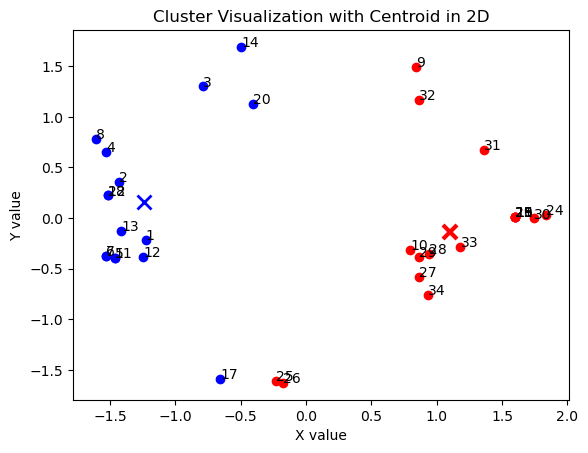

In [49]:
import matplotlib.pyplot as plt

# Example list of points, where each point is (x, y, label)
points = [
    (1, 2, '1'),
    (3, 4, '2'),
    (5, 6, '3'),
    (7, 8, '4')
]

colors = {
    0 : "red" , 
    1 : "blue"
}


cluster_1_points = [point for i,point in enumerate(D_reduced) if labels[i] == 0]
x1, y1 = zip(*[(x, y) for x, y in cluster_1_points])
plt.scatter(x1, y1, color='blue', label='Nodes in Cluster 1')

# Plot nodes in cluster 2
cluster_2_points = [point for i, point in enumerate(
    D_reduced) if labels[i] == 1]
x1, y1 = zip(*[(x, y) for x, y in cluster_2_points])
plt.scatter(x1, y1, color='red', label='Nodes in Cluster 2')


# # Create a scatter plot
# for i,X in enumerate( D_reduced):
#     plt.scatter(X[0], X[1], label=f"Node in cluster 2" if labels[i] else f"Node in cluster 1" ,color = colors[labels[i]])

# Annotate each point with its label
for i,X in enumerate( D_reduced):
    plt.text(X[0], X[1], f"{i+1}")

center_blue = centers[0]
plt.plot(center_blue[0], center_blue[1], marker='x', markersize=10, markeredgewidth=2, color='blue', linestyle='None' , label = "Center of blue cluster")

center_red = centers[1]
plt.plot(center_red[0], center_red[1], marker='x', markersize=10,
         markeredgewidth=3, color='red', linestyle='None', label="Center of red cluster")

# ellipse_blue = Ellipse(center_blue, width=4, height=6,
#                        edgecolor='blue', fill=False, linestyle='--')
# plt.gca().add_patch(ellipse_blue)

# # Add an Ellipse (egg-shaped) around the center of the red cluster
# # Adjust width and height to achieve the desired 'egg' shape
# ellipse_red = Ellipse(center_red, width=2, height=6,
#                       edgecolor='red', fill=False, linestyle='--')
# plt.gca().add_patch(ellipse_red)


# Optionally, add a legend, title, and axis labels
plt.title('Cluster Visualization with Centroid in 2D')
plt.xlabel('X value')
plt.ylabel('Y value')
# plt.legend(fontsize='small')

# Show the plot
plt.show()

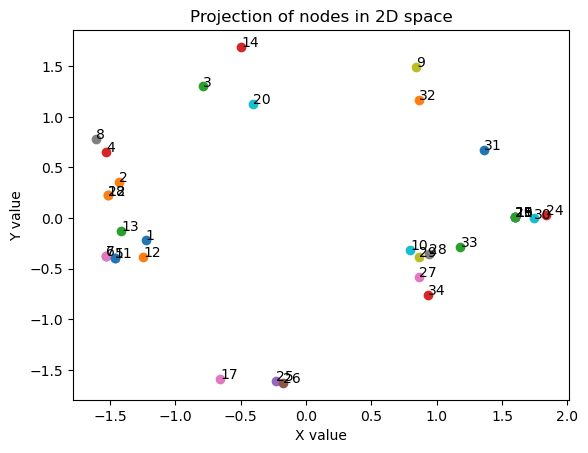

In [48]:

for i, X in enumerate(D_reduced):
    plt.scatter(X[0], X[1], label=f"{i+1}")

# Annotate each point with its label
for i, X in enumerate(D_reduced):
    plt.text(X[0], X[1], f"{i+1}")

# Optionally, add a legend, title, and axis labels
plt.title('Projection of nodes in 2D space')
plt.xlabel('X value')
plt.ylabel('Y value')

# Show the plot
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def initializeCentroids(k: int, points: np.ndarray) -> np.ndarray:
  '''
  Randomly selects k points as inital centroids locations
  k: no. of clusters
  points: n x d, where is n the number of points & d is no. of dimensions (d=2 for now)
  '''
  indices = []
  n = points.shape[0]

  if k > len(points):
    print("Error: k is greater than the number of points")
    return
  else:
    while len(indices) < k:
      index = np.random.randint(low=0, high=n)
      if not index in indices:
        indices.append(index)
    return points[indices, :]


def assignPointsToClusters(centroids: np.ndarray, points: np.ndarray) -> np.ndarray:
  '''
  Assigns each point to the closest centroid
  centroids: k x d, where is k the number of clusters & d is no. of dimensions (d=2 for now)
  points: n x d, where is n the number of points & d is no. of dimensions (d=2 for now)
  
  RETURNS clusters: n x 1, where is n the number of points
  '''
  n = points.shape[0]  # no. of points
  k = centroids.shape[0]  # no. of clusters``
  clusters = np.zeros(shape=(n,))  # n x 1, where n is the number of points

  # for each point, finds the distance to each centroid
  for i in range(n):
    distances = []
    for j in range(k):
      # euclidean distance
      distances.append(np.linalg.norm(points[i, :] - centroids[j, :]))

    clusters[i] = distances.index(min(distances))
  return clusters


def optimizeCentroids(centroids: np.ndarray, points: np.ndarray, clusters: np.ndarray) -> np.ndarray:
  '''
  Updates the centroid locations to be the mean of the points assigned to the cluster
  centroids: k x d, where is k the number of clusters & d is no. of dimensions (d=2 for now)
  points: n x d, where is n the number of points & d is no. of dimensions (d=2 for now)
  clusters: 
  '''
  n = points.shape[0]  # no. of points
  k = centroids.shape[0]  # no. of clusters
  # k x d, where k is the number of clusters & d is no. of dimensions (d=2 for now)
  newCentroids = np.zeros(shape=(k, points.shape[1]))

  # for each cluster
  for i in range(k):
    # get the points assigned to that cluster
    pointsInCluster = points[clusters == i]
    newCentroids[i, :] = np.mean(pointsInCluster, axis=0)
  return newCentroids


def generateClusters(n_points, n_clusters, points_range=[1.0, 20.0], std=1) -> np.ndarray:
  """
    n_points: number of points
    n_clusters: number of clusters the points are distributed in
    points_range (Optional) : range in which points lie [default = 1.0 --> 20.0]
    * Due to randomeness points may lie outside the given range +/- std devation
    std (Optional): standard devation used for normal curve [default = 1]
    """
  # Choose center points of clusters from the range given
  centers = np.random.uniform(
      points_range[0], points_range[1], size=(n_clusters, 2))

  # Initialize empty array, how many points in each cluster
  n_points_for_centers = np.ones(n_clusters)
  # Use floor division to equally distribute the points in clusters equally
  n_points_for_centers.fill(n_points // n_clusters)
  # Add points to clusters that are left
  for i in range(n_points % n_clusters):
    n_points_for_centers[i] += 1
  # Convert this to int , if not gives error later
  n_points_for_centers = [int(i) for i in n_points_for_centers]

  points = []
  for i, n in enumerate(n_points_for_centers):
    # Generate poins on each center using normal distribution
    points.append(centers[i] + np.random.normal(scale=std, size=(n, 2)))
  # Concatenate all generated points
  points = np.concatenate(points)

  return points


class KmeansAnimate2D():
  def __init__(self, k: int, data: np.ndarray, startCentroids=None, columns: list = None, lables: list = None):
    """
    k: no. of clusters
    data: n x 2, n: number of points
    startCentroids (optional) = k x 2, k: number of clusters 
    columns (optional) = list of strings, x and y axis labels (length 2)
    lables (optional) = list of strings, labels for each cluster, order should match centroids
    """
    self.k = k

    # 2d data allowed for now
    if data.shape[1] != 2:
      raise RuntimeError('data must be of shape n x 2')

    if not isinstance(data, np.ndarray):
      raise RuntimeError('data must be of type numpy.ndarray')

    self.points = data
    self.initialCentroids = startCentroids
    self.columns = columns
    self.cluster_lables = lables

  def _generatorFuncAnimate(self):
    '''
    Animates the kmeans algorithm
    points: n x d, where is n the number of points & d is no. of dimensions 
    centroids: k x d, where is k the number of clusters & d is no. of dimensions 
    clusters: assigned to clusters to points
    initialCentroids (optional) = k x d, where is k the number of clusters & d is no. of dimensions 
    '''

    if self.initialCentroids is None:
      centroids = initializeCentroids(self.k, self.points)
    elif self.initialCentroids.shape[0] != self.k:
      RuntimeError('initialCentroids shape != k')
    else:
      centroids = self.initialCentroids

    clusters = assignPointsToClusters(centroids, self.points)
    newCentroids = optimizeCentroids(centroids, self.points, clusters)

    initalIteration = True
    iterations = 0
    while not np.array_equal(centroids, newCentroids):
      if initalIteration:
        pass
        initalIteration = False
      else:
        centroids = newCentroids
        clusters = assignPointsToClusters(centroids, self.points)
        newCentroids = optimizeCentroids(centroids, self.points, clusters)

      iterations += 1
      yield centroids, clusters, iterations

  def _animate(self, generatorFuncData,) -> None:
    '''
    Animates the kmeans algorithm
    i: current iteration
    points: n x d
    centroids: k x d
    clusters: assigned clusters for points
    '''
    (centroids, clusters, i) = generatorFuncData
    points = self.points

    plt.cla()
    cluster_scatter = plt.scatter(
        points[:, 0], points[:, 1], c=clusters, s=75, cmap='jet', marker='x')
    plt.scatter(centroids[:, 0], centroids[:, 1], edgecolors="black",
                c=assignPointsToClusters(centroids, centroids), cmap='jet', s=50)

    if not self.columns == None and len(self.columns) == 2:
      plt.xlabel(self.columns[0])
      plt.ylabel(self.columns[1])

    if not self.cluster_lables == None and len(self.cluster_lables) == self.k:
      plt.legend(handles=cluster_scatter.legend_elements()
                 [0], labels=self.cluster_lables)

    plt.title(f'Iteration: {i}\nK: {self.k}')

  def animate(self, interval=500) -> None:
    fig, ax = plt.subplots()
    animObj = animation.FuncAnimation(
        fig,
        self._animate,
        self._generatorFuncAnimate,
        interval=interval
    )

    self._animObj = animObj
    plt.show()

  def saveGIF(self, filename: str, fps=10) -> None:
    '''
    Saves the animation as a gif

    filename = name of the gif file, don't mention the extension
    '''
    self._animObj.save(filename+'.gif', writer='pillow', fps=fps)

  def animate_jupyter_nb(self):
    fig, ax = plt.subplots()
    animObj = animation.FuncAnimation(
        fig,
        self._animate,
        self._generatorFuncAnimate,
        interval=500
    )
    from IPython.display import HTML, display
    display(HTML(animObj.to_jshtml()))
    self._animObj = animObj
    plt.close()

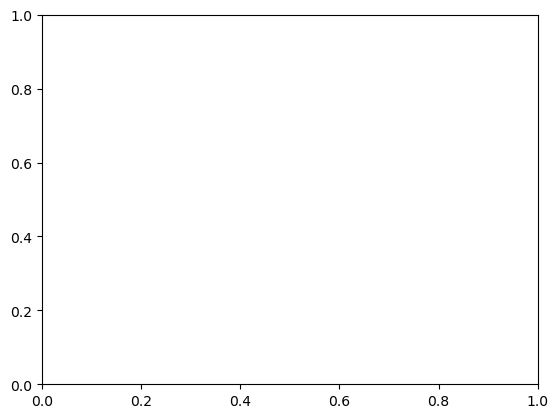

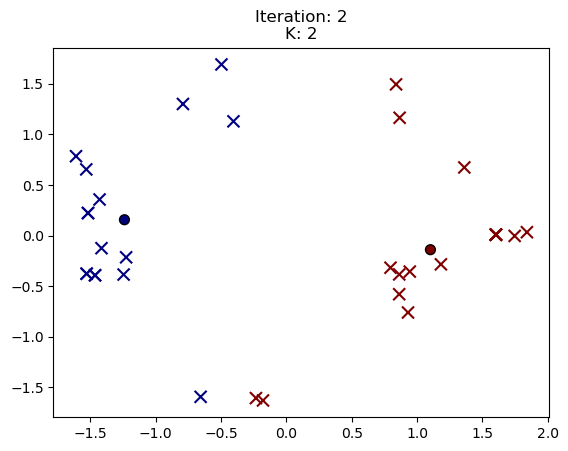

In [10]:
kmeans = KmeansAnimate2D(k=2, data=D_reduced , startCentroids= D_reduced[[0,33]])
kmeans.animate()
# to save the animation as kmeans-animation.gif
kmeans.saveGIF("kmeans-animation")

In [ ]:
len([{'nodes': [0, 1, 17], 'weight': 0.6018518518518519}, {'nodes': [0, 1, 2, 3, 13], 'weight': 0.5041666666666667}, {'nodes': [0, 1, 2, 3, 7], 'weight': 0.4741666666666666}, {'nodes': [0, 1, 19], 'weight': 0.6574074074074074}, {'nodes': [0, 1, 21], 'weight': 0.6018518518518519}, {'nodes': [0, 4, 10], 'weight': 0.625}, {'nodes': [0, 4, 6], 'weight': 0.6666666666666666}, {'nodes': [0, 5, 10], 'weight': 0.6666666666666666}, {'nodes': [0, 5, 6], 'weight': 0.625}, {'nodes': [0, 8, 2], 'weight': 0.7208333333333332}, {'nodes': [0, 12, 3], 'weight': 0.6041666666666666}, {'nodes': [2, 32, 8], 'weight': 0.7277777777777779}, {'nodes': [5, 16, 6], 'weight': 0.5833333333333334}, {
    'nodes': [33, 32, 8, 30], 'weight': 0.5855392156862745}, {'nodes': [33, 32, 14], 'weight': 0.5727124183006536}, {'nodes': [33, 32, 15], 'weight': 0.5727124183006536}, {'nodes': [33, 32, 18], 'weight': 0.5727124183006536}, {'nodes': [33, 32, 20], 'weight': 0.5727124183006536}, {'nodes': [33, 32, 22], 'weight': 0.5727124183006536}, {'nodes': [33, 32, 23, 29], 'weight': 0.5618464052287582}, {'nodes': [33, 32, 31], 'weight': 0.6462418300653594}, {'nodes': [33, 26, 29], 'weight': 0.6274509803921569}, {'nodes': [33, 27, 23], 'weight': 0.7441176470588236}, {'nodes': [33, 28, 31], 'weight': 0.7761437908496732}, {'nodes': [24, 25, 31], 'weight': 0.7222222222222223}])

25